In [1]:
!pip install -i https://test.pypi.org/simple my-krml-25176165==2025.0.2.1 --upgrade --extra-index-url https://pypi.org/simple

Looking in indexes: https://test.pypi.org/simple, https://pypi.org/simple

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-11.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.5-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl (270 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.6 MB/s eta 0:00:00
Using cached pillow-11.3.0-cp311-cp311-macosx_11_0_arm64.whl (4.7 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m6/8 [matplotlib]

[notice] A new release of 

In [3]:
# Imports & setup

In [4]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parents[2] / "src"))

%load_ext autoreload
%autoreload 2

In [5]:
# Load NBA draft data

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, classification_report
from joblib import dump
import os

train_df = pd.read_csv("/Users/amanda/nba_draft_prediction/data/raw/train.csv") 
test_df = pd.read_csv("/Users/amanda/nba_draft_prediction/data/raw/test.csv")

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nTraining data info:")
train_df.info()

Training data shape: (14774, 62)
Test data shape: (1297, 61)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14774 entries, 0 to 14773
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 14774 non-null  object 
 1   conf                 14774 non-null  object 
 2   GP                   14774 non-null  int64  
 3   Min_per              14774 non-null  float64
 4   Ortg                 14774 non-null  float64
 5   usg                  14774 non-null  float64
 6   eFG                  14774 non-null  float64
 7   TS_per               14774 non-null  float64
 8   ORB_per              14774 non-null  float64
 9   DRB_per              14774 non-null  float64
 10  AST_per              14774 non-null  float64
 11  TO_per               14774 non-null  float64
 12  FTM                  14774 non-null  int64  
 13  FTA                  14774 non-null  int64  
 14  FT_p

In [7]:
# Exploratory Data Analysis (EDA)

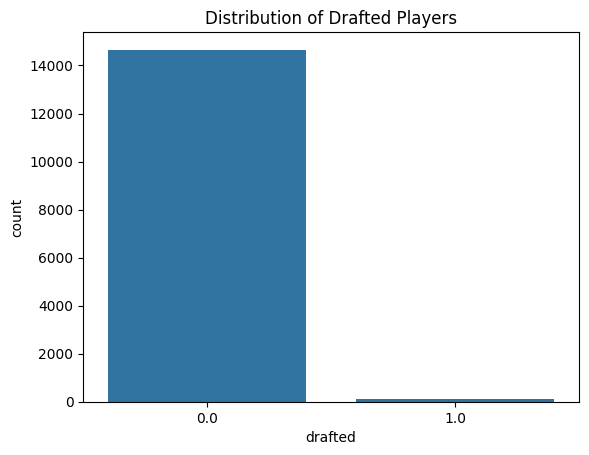

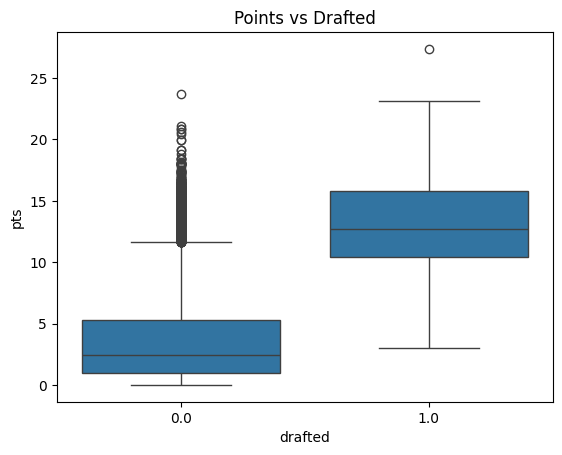

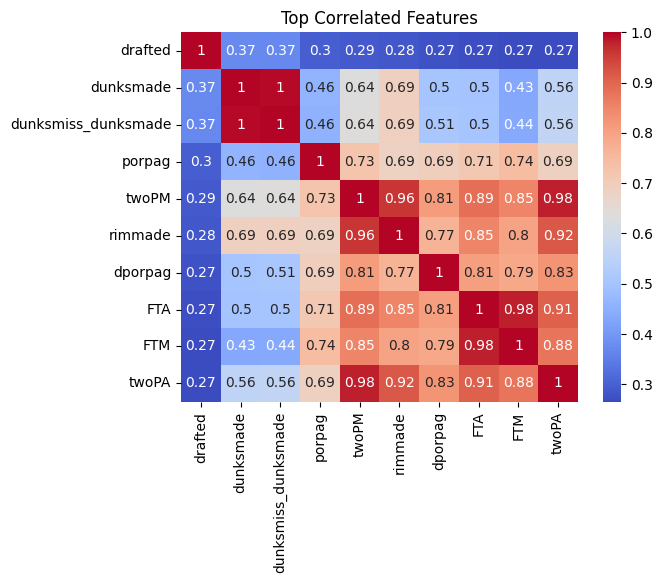

In [8]:
# Target variable distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=train_df['drafted'])
plt.title("Distribution of Drafted Players")
plt.show()

# pts
sns.boxplot(x='drafted', y='pts', data=train_df)
plt.title("Points vs Drafted")
plt.show()

# Plot heatmap
import numpy as np
corr = train_df.corr(numeric_only=True)
top_corr = corr['drafted'].abs().sort_values(ascending=False).head(10).index
sns.heatmap(train_df[top_corr].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features")
plt.show()


In [9]:
# Prepare Data

In [10]:
# copy data
train_clean = train_df.copy()

# missing values
threshold = 0.5
missing_rate = train_clean.isnull().mean()
drop_cols = missing_rate[missing_rate > threshold].index.tolist()
train_clean.drop(columns=drop_cols, inplace=True)

# Fill in the remaining fields
for col in train_clean.columns:
    if train_clean[col].dtype == 'object':
        train_clean[col] = train_clean[col].fillna(train_clean[col].mode()[0])
    else:
        train_clean[col] = train_clean[col].fillna(train_clean[col].mean())

# Separate the target column
target = train_clean.pop("drafted") 

# Categorical / numerical column classification
num_cols = list(train_clean.select_dtypes('number').columns)
cat_cols = list(set(train_clean.columns) - set(num_cols))

# One-hot encoding
from sklearn.preprocessing import OneHotEncoder, StandardScaler
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
features_cat = ohe.fit_transform(train_clean[cat_cols])
features_cat = pd.DataFrame(features_cat, columns=ohe.get_feature_names_out())

# Scaling
scaler = StandardScaler()
features_num = pd.DataFrame(scaler.fit_transform(train_clean[num_cols]), columns=num_cols)

# merge data
features = pd.concat([features_num, features_cat], axis=1)


# Save the encoder and scaler
from joblib import dump
os.makedirs("../models", exist_ok=True)
dump(ohe, "../models/ohe.joblib")
dump(scaler, "../models/scaler.joblib")

['../models/scaler.joblib']

In [11]:
# Split Dataset

In [13]:
from my_krml_25176165.data.sets import save_sets
save_sets(X_train, y_train, X_val, y_val, X_test, y_test, path='../data/processed/')

In [16]:
from my_krml_25176165.data.sets import split_sets_random
X_train, y_train, X_val, y_val, X_test, y_test = split_sets_random(features, target, test_ratio=0.2)

# Print the dimensions of X_train, X_val, X_test
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

#  Print the dimensions of y_train, y_val, y_test
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

# Import the save_sets() function from my_krml_149874/data/sets.py
from my_krml_25176165.data.sets import save_sets

# Save the sets into the folder data/processed
save_sets(X_train, y_train, X_val, y_val, X_test, y_test, path='../data/processed/')

(8864, 12627)
(2955, 12627)
(2955, 12627)
(8864,)
(2955,)
(2955,)


In [17]:
# Get Baseline Model

In [18]:
# Import DummyRegressor
from sklearn.dummy import DummyRegressor

# Instantiate
base_reg = DummyRegressor(strategy='mean')

# Fit and Predict
base_reg.fit(X_train, y_train)
y_base = base_reg.predict(X_train)

# Import print_regressor_scores() and display scores
from my_krml_25176165.models.performance import print_regressor_scores

print_regressor_scores(y_preds=y_base, y_actuals=y_train, set_name='Training')

RMSE Training: 0.0915947573659108
MAE Training: 0.016779199153840137


In [19]:
# Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from my_krml_25176165.models.performance import print_regressor_scores

# Build and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on train and validation sets
y_train_pred = lin_reg.predict(X_train)
y_val_pred = lin_reg.predict(X_val)

# Model evaluation
print_regressor_scores(y_preds=y_train_pred, y_actuals=y_train, set_name='Training')
print_regressor_scores(y_preds=y_val_pred, y_actuals=y_val, set_name='Validation')


RMSE Training: 2.6672061644051832e-15
MAE Training: 1.9009267274836624e-15
RMSE Validation: 0.06609118770047813
MAE Validation: 0.012778472093805426


In [21]:
!pip install matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [22]:
# Validation Set

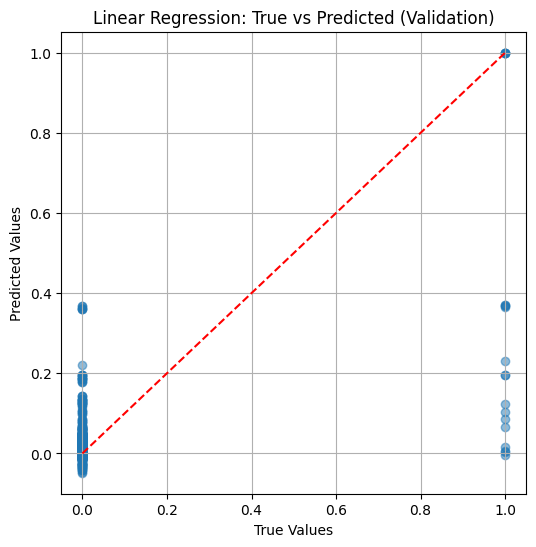

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: True vs Predicted (Validation)")
plt.grid(True)
plt.show()


In [24]:
# Residual Plot

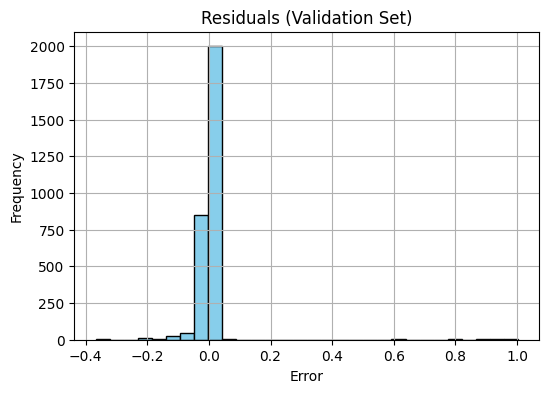

In [25]:
residuals = y_val - y_val_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residuals (Validation Set)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [26]:
! git add .
! git commit -m "prepare data and baseline"
! git push

[adv_mla_2_poly_model 37b8dd9] prepare data and baseline
 1 file changed, 54 insertions(+), 25 deletions(-)
fatal: The current branch adv_mla_2_poly_model has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin adv_mla_2_poly_model

To have this happen automatically for branches without a tracking
upstream, see 'push.autoSetupRemote' in 'git help config'.

